In [1]:
import os
import ipyvolume as ipv
import tyssue
import json
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random
import sys
import logging
import tyssue.io.hdf5 as hdf5
from IPython.display import Image
from scipy import optimize
from tyssue.draw import sheet_view

from tyssue import Sheet
from tyssue import SheetGeometry

##### Own functions
import src.cellDivisionOld as cellDivisionOld
import src.cellDivision as cellDivision
import src.vertexModel as vertexModel
import src.inputMechanicalParameters as inputMechanicalParameters
import src.auxFunctions as auxFunctions
from tyssue.topology import add_vert

from tyssue.draw.plt_draw import create_gif
from tyssue.draw import highlight_faces, create_gif
from IPython.display import Image

from tyssue.topology.base_topology import add_vert, close_face, collapse_edge, remove_face
from tyssue.topology.base_topology import split_vert as base_split_vert

from matplotlib import cm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

from math import sqrt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
import json

import pickle 
import gzip

import imageio

import logging
logger = logging.getLogger(name=__name__)

import warnings
warnings.filterwarnings("ignore")


collision solver could not be imported You may need to install CGAL and re-install tyssue


In [2]:
# Initialize cellmap, geometry, and energy contributions model
cellmap, geom, energyContributions_model = vertexModel.initialize(40)
cellmap = inputMechanicalParameters.update(cellmap)
energyContributions_model.compute_energy(cellmap)

# Track mean area and mean edge length changes over time
mean_areas = []        # To store mean area at each step
mean_edge_lengths = [] # To store mean edge length at each step

# Solve using Euler method and track histor
[cellmap, geom, model, history, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=100)

CGAL-based mesh generation utilities not found, you may need to install CGAL and build from source
C++ extensions are not available for this version
Topology changed!


In [3]:
def view_blue(cellmap, geom, highlight_edges=None):
    """
    Visualizes the cell map with options to show vertices and adjust vertex size.
    Includes edge highlighting for specified edges.
    
    Parameters:
    - cellmap: The cell map containing the geometry.
    - geom: Geometry object to update and use for visualization.
    - highlight_edges: List of edge indices to highlight (optional). Default is None.
    """
    # Update the geometry
    geom.update_all(cellmap)

    # Set default edge color (corresponding to blue in the 'bwr' colormap)
    default_color = -1  # Use -1 for blue in 'bwr' colormap

    # Reset all edge colors and widths
    cellmap.edge_df["color_edges"] = default_color  # Default blue color for non-highlighted edges
    cellmap.edge_df['edge_width'] = 1  # Default edge width

    # Create the plot with edge highlighting
    fig, ax = sheet_view(
        cellmap,
        mode="2D",
        face={"visible": False},
        edge={"head_width": 0.0, "color": 'blue', "colormap": "bwr", "width": cellmap.edge_df['edge_width'], "alpha": 1.0},  # Highlight edges if specified
        #vert={"visible": True, "s": 30, "color": "red", "alpha": 1.0}  # Keep vertices visible and red
        vert={"visible": False}
    )
    
    fig.set_size_inches(15, 15)
    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax


(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

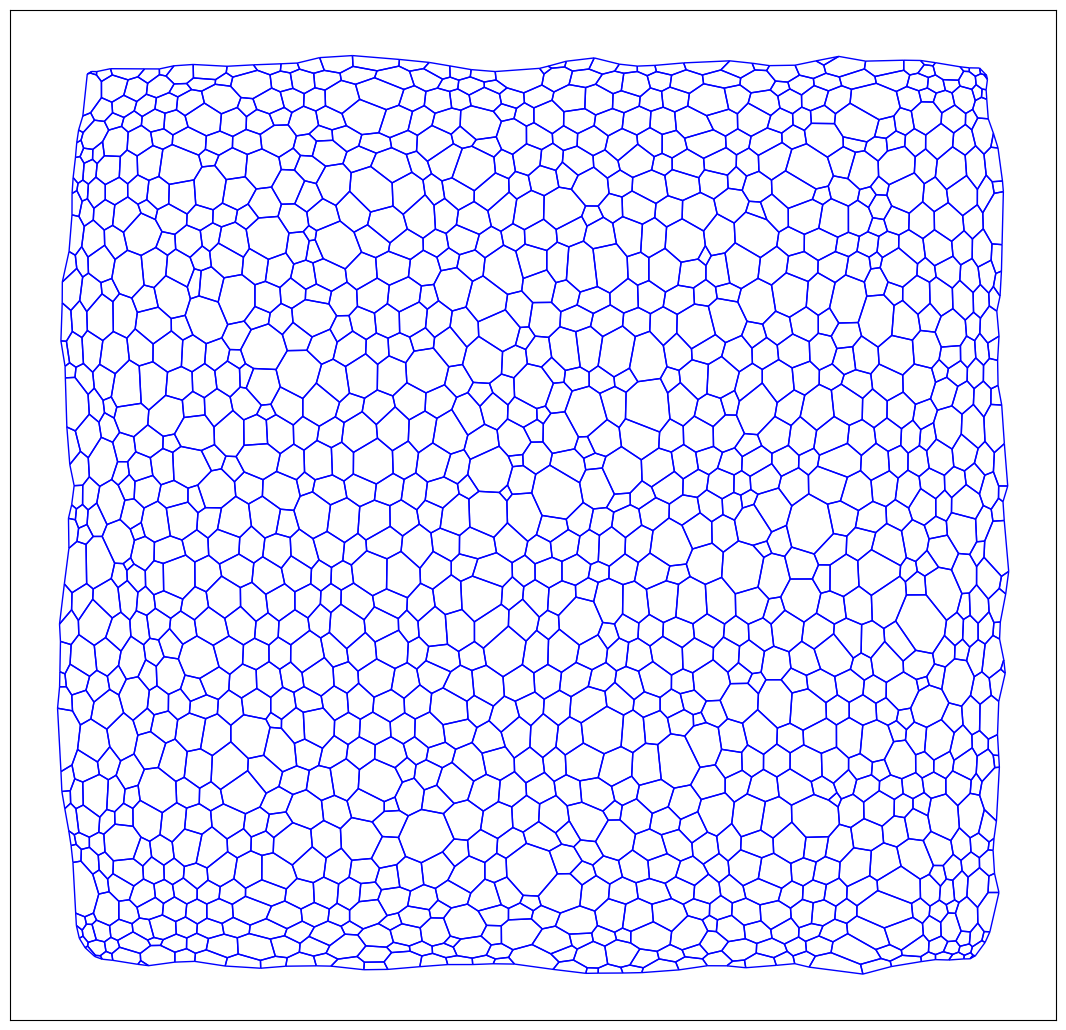

In [8]:
view_blue(cellmap, geom, highlight_edges=None)

In [9]:
cellmap.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,ry,sub_area,is_active,length_elasticity,prefered_length,uz,length_elasticity_ECM,length_elasticity_FRC,color_edges,edge_width
edge,,,,,,,,,,,,,,,,,,,,,
0,15,0.200332,0.837134,223,6,-0.051673,0.835537,36.953336,6.999099,36.901663,...,-0.395677,0.100166,1,190.078461,1.000000e-07,0.57735,154.634538,35.443923,-1,1
1,7,0.423575,1.467168,149,8,0.329647,1.429656,36.784911,4.873985,37.114558,...,-0.678150,0.211787,1,66.087330,1.000000e-07,0.57735,36.389123,29.698208,-1,1
2,18,0.069706,0.226745,186,6,-0.205541,-0.095740,36.953336,6.999099,36.747795,...,0.371719,0.034853,1,232.989064,1.000000e-07,0.57735,194.409079,38.579984,-1,1
3,6,0.106626,0.226745,223,18,0.205541,0.095740,36.747795,6.903359,36.953336,...,-0.491417,0.053313,1,306.955976,1.000000e-07,0.57735,273.740986,33.214990,-1,1
4,19,0.298041,0.396728,149,7,-0.396728,-0.000218,37.114558,6.303640,36.717830,...,0.751505,0.149021,1,103.689391,1.000000e-07,0.57735,69.022977,34.666414,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8147,322,0.257304,1.385842,935,866,-0.046780,-1.385052,3.019020,27.765441,2.972240,...,0.820208,0.128652,1,74.069378,1.000000e-07,0.57735,39.685348,34.384030,-1,1
8148,709,0.059479,0.548264,449,46,-0.011807,-0.548137,2.935107,14.338345,2.923299,...,0.292666,0.029739,1,277.629181,1.000000e-07,0.57735,244.723230,32.905951,-1,1
8149,46,0.207938,1.104491,487,1342,-0.020714,-1.104296,2.955821,15.442642,2.935107,...,0.645826,0.103969,1,168.782905,1.000000e-07,0.57735,139.842360,28.940545,-1,1


In [ ]:
# After each time step, record the mean area and mean edge length
for t, cellmap in solver.history:
    mean_area = cellmap.face_df['area'].mean()
    mean_edge_length = cellmap.edge_df['length'].mean()
    mean_areas.append(mean_area)
    mean_edge_lengths.append(mean_edge_length)

# Plotting the mean area and mean edge length over time to check if they stabilize
time_steps = range(len(mean_areas))
plt.figure(figsize=(12, 6))

# Plot Mean Area
plt.plot(time_steps, mean_areas, marker='o', linestyle='-', color='blue', label='Mean Area')

# Plot Mean Edge Length
plt.plot(time_steps, mean_edge_lengths, marker='s', linestyle='--', color='green', label='Mean Edge Length')

# Customize the plot
plt.title('Mean Area and Mean Edge Length Over Time During Simulation', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Measurement Value', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Initialize lists to store mean inside area and mean inside edge length
mean_inside_areas = []
mean_inside_lengths = []
max_layers = 12  # Define max layers to exclude boundary layers

# Identify inside faces and edges, excluding boundary layers once at the start
boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

# Iterate over each time step in solver history
for t, cellmap in solver.history:
    # Calculate the mean area for the pre-identified inside faces
    mean_inside_area = cellmap.face_df.loc[inside_faces, 'area'].mean()
    mean_inside_areas.append(mean_inside_area)
    
    # Calculate the mean length for the pre-identified inside edges
    mean_inside_length = cellmap.edge_df.loc[inside_edges, 'length'].mean()
    mean_inside_lengths.append(mean_inside_length)

# Plotting the mean inside area and mean inside edge length over time to check if they stabilize
time_steps = range(len(mean_inside_areas))



In [ ]:
# Plot Mean Inside Area and Mean Inside Edge Length on the same graph with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Mean Inside Area on the primary y-axis
ax1.plot(time_steps, mean_inside_areas, marker='o', linestyle='-', color='blue', label='Mean Inside Area')
ax1.set_xlabel('Time Steps', fontsize=12)
ax1.set_ylabel('Mean Inside Area', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis for Mean Inside Edge Length
ax2 = ax1.twinx()
ax2.plot(time_steps, mean_inside_lengths, marker='s', linestyle='--', color='green', label='Mean Inside Edge Length')
ax2.set_ylabel('Mean Inside Edge Length', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Title and legend
plt.title('Mean Inside Area and Mean Inside Edge Length Over Time During Simulation', fontsize=16)
fig.tight_layout()  # Adjust layout to fit both y-axes without overlap

ax1.set_ylim(0.0, 1.2)  # Modify the range as needed
ax2.set_ylim(0.0, 0.7) 

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot Mean Inside Area on its own graph with adjusted y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(time_steps, mean_inside_areas, marker='o', linestyle='-', color='blue', label='Mean Inside Area')
ax1.set_xlabel('Time Steps', fontsize=12)
ax1.set_ylabel('Mean Inside Area', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Mean Inside Area Over Time During Simulation', fontsize=16)
ax1.grid(True)

# Adjust y-axis limits to reduce the appearance of minor decreases
ax1.set_ylim(0.0, 1.2)  # Modify the range as needed
plt.tight_layout()

plt.show()

# Plot Mean Inside Edge Length on its own graph with adjusted y-axis
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(time_steps, mean_inside_lengths, marker='s', linestyle='--', color='green', label='Mean Inside Edge Length')
ax2.set_xlabel('Time Steps', fontsize=12)
ax2.set_ylabel('Mean Inside Edge Length', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title('Mean Inside Edge Length Over Time During Simulation', fontsize=16)
ax2.grid(True)

# Adjust y-axis limits to reduce the appearance of minor decreases
ax2.set_ylim(0.0, 0.7)  # Modify the range as needed
plt.tight_layout()

plt.show()


In [ ]:
# Plot all inside areas for each time point
fig, ax1 = plt.subplots(figsize=(10, 6))

# Iterate over each time step in solver history
for t, cellmap_during_step in solver.history:
    # Extract area values for the inside faces at this time step
    inside_areas = cellmap_during_step.face_df.loc[inside_faces, 'area'].values
    # Plot all inside areas for this time point as a scatter plot
    ax1.scatter([t] * len(inside_areas), inside_areas, color='blue', alpha=0.5, s=10)

# Customize the plot
ax1.set_xlabel('Time Steps', fontsize=12)
ax1.set_ylabel('Inside Face Areas', color='blue', fontsize=12)
ax1.set_title('All Inside Areas Over Time During Simulation', fontsize=16)
ax1.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Ensure the folder for saving PNG frames exists
gif_folder = "initialising_1000_endTime"

if not os.path.exists(gif_folder):
    os.makedirs(gif_folder)
    print(f"Directory created: {gif_folder}")

frame_count = 0  # To keep track of frame numbering

# Iterate through each time point in solver history
for t, cellmap_during_step in solver.history:
    # Generate the frame filename
    frame_filename = os.path.join(gif_folder, f"snapshot_{frame_count:03d}.png")
    
    # Plot and save the cellmap at this time point
    fig, ax = view_blue(cellmap_during_step, geom)  # Ensure `view_blue` is available
    fig.savefig(frame_filename)
    plt.close(fig)
    
    # Print or track the saved frame
    print(f"Saved snapshot: {frame_filename}")
    frame_count += 1


In [ ]:
# Initialize a list to store the area of face 804 at each time point
face_804_areas = []

# Iterate over each time step in solver history
for t, cellmap in solver.history:
    # Get the area of face 804 at the current time step
    area_804 = cellmap.face_df.loc[804, 'area']
    face_804_areas.append(area_804)

# Print or analyze the area of face 804 over time
print("Areas of face 804 over time:", face_804_areas)


In [ ]:
import matplotlib.pyplot as plt

# Define the time steps as the x-axis
start, end = 700, 1000
time_steps = range(len(face_804_areas))

# Slice the data for time steps 700 to 1000
time_steps_subset = time_steps[start:end]
face_804_areas_subset = face_804_areas[start:end]

# Plot the area of face 804 over time for the subset
plt.figure(figsize=(10, 6))
plt.plot(time_steps_subset, face_804_areas_subset, marker='o', linestyle='-', color='purple', label='Area of Face 804')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Area of Face 804', fontsize=12)
plt.title('Area of Face 804 Over Time (Time Steps 700-1000)', fontsize=16)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
cellmap.face_df

In [ ]:
def view(cellmap, geom):
    #cellmap.remove(cellmap.cut_out([[5, 35], [5, 35]]), trim_borders=True)
    geom.update_all(cellmap)
    if cellmap.edge_df['length_elasticity'].max():
        ecolor = cellmap.edge_df['length_elasticity']
    else:
        ecolor = "#aaaaaa"
        
    fig, ax = sheet_view(
        cellmap,
        mode="2D",
        face={"visible": False},
        edge={"head_width": 0.0, "color": ecolor, "width": 2},
        vert={"visible": False}
    )
    fig.set_size_inches(20, 20)
    ax.set_xticks([])
    ax.set_yticks([])

    
    return fig, ax

In [ ]:
view_blue(cellmap, geom, highlight_edges=None)

In [ ]:
edges = [10,20,30]

In [ ]:
def view_with_highlights(cellmap, geom, highlight_vertex=None, highlight_edges=None):
    """
    Visualizes the cellmap with options to show and highlight specific vertices.
    Includes edge highlighting and optional vertex highlighting.
    
    Parameters:
    - cellmap: The cell map containing the geometry.
    - geom: Geometry object to update and use for visualization.
    - highlight_vertex: List of vertex indices to highlight (optional). Default is None.
    """
    # Update the geometry
    geom.update_all(cellmap)

    # Set default edge color and width
    cellmap.edge_df["color_edges"] = -1  # Default blue color for non-highlighted edges
    cellmap.edge_df['edge_width'] = 1  # Default edge width

    # Ensure each vertex has its own color and size setting
    cellmap.vert_df['color_verts'] = 'blue'  # Default color for all vertices
    cellmap.vert_df['vert_size'] = 3         # Default size for all vertices

    # Apply specific color and size for highlighted vertices if provided
    if highlight_vertex:
        cellmap.vert_df.loc[highlight_vertex, 'color_verts'] = 'red'  # Highlight color
        cellmap.vert_df.loc[highlight_vertex, 'vert_size'] = 30        # Larger size for highlighted vertices
        
    if highlight_edges:
        cellmap.edge_df.loc[highlight_edges, 'color_edges'] = 1  # Highlight color
        cellmap.edge_df.loc[highlight_edges, 'edge_width'] = 3      # Larger size for highlighted vertices
        

    # Create the plot with edge and vertex highlighting
    fig, ax = sheet_view(
        cellmap,
        mode="2D",
        face={"visible": False},
        edge={
            "visible": True,
            "head_width": 0.0,
            "color": cellmap.edge_df['color_edges'],  # Dynamic edge colors
            "colormap": "bwr",
            "width": cellmap.edge_df['edge_width'],
            "alpha": 1.0
        },
        vert={
            "visible": True,
            "color": cellmap.vert_df['color_verts'],  # Vertex-specific colors
            "s": cellmap.vert_df['vert_size'],        # Vertex-specific sizes
            "alpha": 1.0
        }
    )
    fig.set_size_inches(15, 15)
    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax


In [ ]:
view_with_highlights(cellmap, geom, highlight_vertex=10, highlight_edges=1)


In [ ]:
# Visualize the edge before division
cellmap.edge_df["color_edges"] = 0
cellmap.edge_df['edge_width'] = 1
cellmap.edge_df.loc[inside_edges, "color_edges"] = 1
cellmap.edge_df.loc[inside_edges, 'edge_width'] = 4

cellmap.face_df["color_faces"] = 0
cellmap.face_df.loc[804, "color_faces"] = 1


specs = {
    'face': {
        'visible': True,
        'color': cellmap.face_df["color_faces"],
    },
    'edge': {
        'visible': True,
        'color': cellmap.edge_df["color_edges"],
        'colormap': 'bwr',
        'width': cellmap.edge_df['edge_width'],
    },
    'vert': {
        'visible': False,
        'color': '#000a4b',
        's': 20,
    }
}

fig, ax = sheet_view(cellmap, **specs)
fig.set_size_inches((15, 15))
plt.show()

In [ ]:
def merge_vertices(sheet, vert0, vert1, vert2=None, reindex=True):
    """Merge the two or three vertices vert0, vert1, and optionally vert2 if they are linked by edges.

    If `reindex` is `True` (the default), resets indexes and topology data.

    Note:
    -----
    It is more efficient to call directly `collapse_edge`.

    """
    logger.debug(f"Merging vertices {vert0, vert1}" + (f", {vert2}" if vert2 else ""))

    # Find the edge between vert0 and vert1
    edges = sheet.edge_df[
        ((sheet.edge_df["srce"] == vert0) & (sheet.edge_df["trgt"] == vert1))
        | ((sheet.edge_df["srce"] == vert1) & (sheet.edge_df["trgt"] == vert0))
    ].index

    if not len(edges):
        raise ValueError(
            f"""No edge found between vertices {vert0} and {vert1}, cannot merge"""
        )

    # Collapse the edge between vert0 and vert1
    collapse_edge(sheet, edges[0], reindex=False)

    # If vert2 is provided, find and collapse the edge between vert0 or vert1 and vert2
    if vert2 is not None:
        edges = sheet.edge_df[
            ((sheet.edge_df["srce"] == vert0) & (sheet.edge_df["trgt"] == vert2))
            | ((sheet.edge_df["srce"] == vert2) & (sheet.edge_df["trgt"] == vert0))
            | ((sheet.edge_df["srce"] == vert1) & (sheet.edge_df["trgt"] == vert2))
            | ((sheet.edge_df["srce"] == vert2) & (sheet.edge_df["trgt"] == vert1))
        ].index

        if not len(edges):
            raise ValueError(
                f"""No edge found between vertices {vert0, vert1} and {vert2}, cannot merge"""
            )

        # Collapse the edge involving vert2
        collapse_edge(sheet, edges[0], reindex=False)

    # Reindex if requested
    if reindex:
        sheet.reindex()

    logger.debug(f"Vertices {vert0, vert1}" + (f", {vert2}" if vert2 else "") + " merged successfully.")



In [ ]:
def ln_divide_FRC(cellmap, edge, geom):

    # function adapted from add_vert in tyssue (https://tyssue.readthedocs.io/en/latest/source/tyssue.topology.html#tyssue.topology.base_topology.add_vert)

    srce, trgt = cellmap.edge_df.loc[edge, ["srce", "trgt"]]

    logger = logging.getLogger(name=__name__)
    logger.debug(f"adding vertex between {srce} and {trgt}")
    
    # find the opposite half-edge

    opposites = cellmap.edge_df[(cellmap.edge_df["srce"] == trgt) & (cellmap.edge_df["trgt"] == srce)]
    opp_edges = opposites.index

    # find any parallel edges

    parallels = cellmap.edge_df[(cellmap.edge_df["srce"] == srce) & (cellmap.edge_df["trgt"] == trgt)]
    
    # creates a new row in vert_df that has a specific srce value

    new_vert = cellmap.vert_df.loc[srce:srce]
    
    # joins the new new_vert row with vert_df

    cellmap.vert_df = pd.concat([cellmap.vert_df, new_vert], ignore_index=True)
    
    # assigns an index to the new_vert at the end of dataframe

    new_vert = cellmap.vert_df.index[-1]
    
    # updates its coordinates with mean of original srce and trgt vertices

    cellmap.vert_df.loc[new_vert, cellmap.coords] = cellmap.vert_df.loc[
    [srce, trgt], cellmap.coords
    ].mean(numeric_only=True)

    cellmap.edge_df.loc[parallels.index, "trgt"] = new_vert
    
    ### add new edges

    cellmap.edge_df = pd.concat([cellmap.edge_df, parallels], ignore_index=True)
    new_edges = cellmap.edge_df.index[-parallels.index.size:]
    
    # update src and trg of new_edges

    cellmap.edge_df.loc[new_edges, "srce"] = new_vert
    cellmap.edge_df.loc[new_edges, "trgt"] = trgt
    
    # add new opposite edges

    new_opp_edges = []

    if len(opposites.index):
        cellmap.edge_df.loc[opposites.index, "srce"] = new_vert
        cellmap.edge_df = pd.concat([cellmap.edge_df, opposites], ignore_index=True)
        new_opp_edges = cellmap.edge_df.index[-opposites.index.size :]
        
    ### assign trgt and srce to new_opposite_edges

        cellmap.edge_df.loc[new_opp_edges, "trgt"] = new_vert
        cellmap.edge_df.loc[new_opp_edges, "srce"] = trgt


    #new_length_elasticity_FRC = cellmap.edge_df['length_elasticity_FRC'].mean()*3

    #cellmap.edge_df.loc[edge, 'length_elasticity_FRC'] = new_length_elasticity_FRC
    #cellmap.edge_df.loc[new_edges, "length_elasticity_FRC"] = new_length_elasticity_FRC
    #cellmap.edge_df.loc[new_opp_edges, "length_elasticity_FRC"] = new_length_elasticity_FRC
    #cellmap.edge_df.loc[opp_edges, 'length_elasticity_FRC'] = new_length_elasticity_FRC


    #new_prefered_length_FRC = cellmap.edge_df["length"].mean()/4

    #cellmap.edge_df.loc[edge, 'prefered_length'] = new_prefered_length_FRC
    #cellmap.edge_df.loc[new_edges, "prefered_length"] = new_prefered_length_FRC
    #cellmap.edge_df.loc[new_opp_edges, "prefered_length"] = new_prefered_length_FRC
    #cellmap.edge_df.loc[opp_edges, 'prefered_length'] = new_prefered_length_FRC


    # ## Sheet special case
    if len(new_edges) == 1:
        new_edges = new_edges[0]
    if len(new_opp_edges) == 1:
        new_opp_edges = new_opp_edges[0]
    elif len(new_opp_edges) == 0:
        new_opp_edges = None
        
    #print(cellmap.vert_df)

    geom.update_all(cellmap)
    cellmap.reset_index()
    cellmap.reset_topo()

    return new_vert, new_edges, new_opp_edges, opp_edges

### Adding division and apoptosis together - both by threshold

In [ ]:
def dynamic_divide_and_apoptosis(cellmap_init, length_threshold, collapse_threshold, gif_folder, max_cycles, max_layers):
    """
    Dynamic simulation of edge division and apoptosis under specified rules.
    Edges longer than length_threshold are divided, edges shorter than collapse_threshold are collapsed (apoptosis).
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges ONCE for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Total number of inside edges for this cycle
        total_inside_edges = len(inside_edges)

        # Filter for Division: Edges longer than the length_threshold
        edges_to_divide = cellmap.edge_df.loc[inside_edges][cellmap.edge_df['length'] >= length_threshold]
        divided_edges = set()  # Track divided edges to avoid reprocessing

        # Filter for Collapse (Apoptosis): Edges shorter than the collapse_threshold
        edges_to_collapse = cellmap.edge_df.loc[inside_edges][cellmap.edge_df['length'] <= collapse_threshold]
        collapsed_edges = set()  # Track collapsed edges to avoid reprocessing

        # Perform division (only on inside edges)
        for edge_id in edges_to_divide.index:
            if edge_id in divided_edges:
                continue
            print(f"Dividing edge: {edge_id}")
            new_vert, new_edges, new_opp_edges, opp_edges = ln_divide_FRC(cellmap, edge_id, geom)
            divided_edges.add(edge_id)  # Mark edge as divided

        # Perform collapse (apoptosis) (only on inside edges)
        if edges_to_collapse.empty:
            print(f"No edges found shorter than {collapse_threshold}. Skipping collapse operation.")
        else:
            for edge_id in edges_to_collapse.index:
                if edge_id in collapsed_edges:
                    continue

                edge = cellmap.edge_df.loc[edge_id]
                srce_vertex = edge['srce']
                trgt_vertex = edge['trgt']

                print(f"Collapsing edge {edge_id} with vertices {srce_vertex} and {trgt_vertex}")

                # Collapse the edge by merging the vertices
                new_vertex_id = max(cellmap.vert_df.index) + 1
                new_vertex_data = {
                    'x': (cellmap.vert_df.loc[srce_vertex, 'x'] + cellmap.vert_df.loc[trgt_vertex, 'x']) / 2,
                    'y': (cellmap.vert_df.loc[srce_vertex, 'y'] + cellmap.vert_df.loc[trgt_vertex, 'y']) / 2
                }
                cellmap.vert_df.loc[new_vertex_id] = new_vertex_data

                # Update connected edges to point to the new vertex, only for inside edges
                connected_edges = cellmap.edge_df[
                    ((cellmap.edge_df["srce"] == srce_vertex) | (cellmap.edge_df["trgt"] == srce_vertex) |
                     (cellmap.edge_df["srce"] == trgt_vertex) | (cellmap.edge_df["trgt"] == trgt_vertex)) &
                    (cellmap.edge_df.index.isin(inside_edges))  # Only process inside edges
                ]
                for _, connected_edge in connected_edges.iterrows():
                    if connected_edge['srce'] == srce_vertex or connected_edge['srce'] == trgt_vertex:
                        cellmap.edge_df.at[connected_edge.name, 'srce'] = new_vertex_id
                    if connected_edge['trgt'] == srce_vertex or connected_edge['trgt'] == trgt_vertex:
                        cellmap.edge_df.at[connected_edge.name, 'trgt'] = new_vertex_id

                # Remove old vertices and the chosen edge
                cellmap.vert_df.drop([srce_vertex, trgt_vertex], inplace=True)
                cellmap.edge_df.drop(edge_id, inplace=True)

                print(f"Collapsed edge {edge_id} into vertex {new_vertex_id}")

                collapsed_edges.add(edge_id)  # Mark edge as collapsed

                # Update geometry and topology
                cellmap.reset_index()
                cellmap.reset_topo()
                geom.update_all(cellmap)

        # Update the geometry and recompute energy after operations
        geom.update_all(cellmap)
        energyContributions_model.compute_energy(cellmap)
        [cellmap, geom, model, history, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, 40)

        # Save frames for this cycle
        for t, cellmap_during_step in solver.history:
            fig, ax = auxFunctions.view(cellmap_during_step, geom)
            frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_frame_{frame_count:03d}.png")
            os.makedirs(os.path.dirname(frame_filename), exist_ok=True)
            fig.savefig(frame_filename, dpi=60)
            plt.close(fig)

            all_frames.append(frame_filename)  # Add frame to the list of all frames
            frame_count += 1

        print(f"Cycle {cycle_count} completed.")

        # Calculate and print percentages of divided and collapsed edges
        divided_percentage = (len(divided_edges) / total_inside_edges) * 100 if total_inside_edges > 0 else 0
        collapsed_percentage = (len(collapsed_edges) / total_inside_edges) * 100 if total_inside_edges > 0 else 0

        print(f"Percentage of edges divided: {divided_percentage:.2f}%")
        print(f"Percentage of edges collapsed: {collapsed_percentage:.2f}%")

        # Break the loop if no edges were divided or collapsed during this cycle
        if len(edges_to_divide) == 0 and len(edges_to_collapse) == 0:
            print("No edges left to divide or collapse. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_FRC_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
dynamic_divide_and_apoptosis(cellmap_init, length_threshold=0.8, collapse_threshold=0.1, gif_folder='division and apoptosis', max_cycles=3, max_layers=6)

### function for collapsing a chosen edge

In [ ]:
def collapse_chosen_edge_and_save_frames(sheet, geom, energyContributions_model, chosen_edge, frame_count, gif_folder):
    """
    Merges the two vertices connected by a chosen edge into a single new vertex,
    reconnects the edges to this new vertex, and saves frames before and after each step.
    Also solves for energy after each merge.

    Parameters:
    - sheet: The current cellmap sheet
    - geom: The geometry object
    - energyContributions_model: The energy model
    - chosen_edge: ID of the edge to collapse
    - frame_count: Current frame count (used for naming)
    - gif_folder: Folder to save frames as PNG
    """
    logger.info(f"Chosen edge: {chosen_edge}")

    # Identify the vertices connected by the chosen edge
    edge = sheet.edge_df.loc[chosen_edge]
    srce_vertex = edge['srce']
    trgt_vertex = edge['trgt']
    
    opposites = sheet.edge_df[(sheet.edge_df["srce"] == trgt_vertex) & (sheet.edge_df["trgt"] == srce_vertex)]


    logger.info(f"Vertices to be merged: {srce_vertex}, {trgt_vertex}")

    # Find all edges connected to srce_vertex and trgt_vertex
    connected_edges_srce = sheet.edge_df[
        (sheet.edge_df["srce"] == srce_vertex) | (sheet.edge_df["trgt"] == srce_vertex)
    ]
    connected_edges_trgt = sheet.edge_df[
        (sheet.edge_df["srce"] == trgt_vertex) | (sheet.edge_df["trgt"] == trgt_vertex)
    ]
    print(f"Number of edges connected to srce_vertex ({srce_vertex}): {len(connected_edges_srce)}")
    print(f"Number of edges connected to trgt_vertex ({trgt_vertex}): {len(connected_edges_trgt)}")

    # Step 1: Merge the two vertices by redirecting the edges
    new_vertex_id = max(sheet.vert_df.index) + 1

    # Average x, y coordinates for the new vertex
    new_vertex_data = {
        'x': (sheet.vert_df.loc[srce_vertex, 'x'] + sheet.vert_df.loc[trgt_vertex, 'x']) / 2,
        'y': (sheet.vert_df.loc[srce_vertex, 'y'] + sheet.vert_df.loc[trgt_vertex, 'y']) / 2,
        'viscosity': (sheet.vert_df.loc[srce_vertex, 'viscosity'] + sheet.vert_df.loc[trgt_vertex, 'viscosity']) / 2,
        'is_active': 1.0  # Assuming the new vertex is active
    }

    # Add the new vertex to vert_df
    sheet.vert_df.loc[new_vertex_id] = new_vertex_data

    # Redirect edges connected to the old vertices to the new vertex
    connected_edges = pd.concat([connected_edges_srce, connected_edges_trgt]).drop_duplicates()
    for _, edge in connected_edges.iterrows():
        if edge['srce'] == srce_vertex or edge['srce'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'srce'] = new_vertex_id
        if edge['trgt'] == srce_vertex or edge['trgt'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'trgt'] = new_vertex_id

    # **Identify the opposite edge** to the chosen edge, borrowing logic from `ln_divide_FRC`
    if not opposites.empty:
        opposite_edge_id = opposites.index[0]
        # Drop both the chosen edge and its opposite edge
        sheet.edge_df.drop([chosen_edge, opposite_edge_id], inplace=True)
        print(f"Dropped chosen edge {chosen_edge} and its opposite edge {opposite_edge_id}.")
    else:
        # Drop only the chosen edge if no opposite edge is found
        sheet.edge_df.drop(chosen_edge, inplace=True)
        print(f"Dropped chosen edge {chosen_edge} (no opposite edge found).")

    # Remove the old vertices
    sheet.vert_df.drop([srce_vertex, trgt_vertex], inplace=True)

    logger.info(f"Merged vertices {srce_vertex} and {trgt_vertex} into vertex {new_vertex_id}.")

    # Check the number of edges connected to the new vertex after reassignment
    new_vertex_connected_edges = sheet.edge_df[
        (sheet.edge_df['srce'] == new_vertex_id) | (sheet.edge_df['trgt'] == new_vertex_id)
    ]
    print(f"Number of edges connected to new_vertex ({new_vertex_id}) after reassignment: {len(new_vertex_connected_edges)}")

    # Step 2: Update geometry and topology
    sheet.reset_index()
    sheet.reset_topo()
    geom.update_all(sheet)

    # Increment the frame count
    frame_count += 1

    # Return the updated sheet and frame count
    return sheet, frame_count, new_vertex_id


### function to divide longest edge and collapse shortest edge

In [ ]:
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np

def dynamic_divide_and_shortest_apoptosis(cellmap_init, gif_folder, max_cycles, max_layers):
    """
    Dynamic simulation of edge division and apoptosis.
    Collapse the shortest inside edge, divide the longest inside edge.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=50)

    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1
        
        
    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Total number of inside edges for this cycle
        total_inside_edges = len(inside_edges)

        # Step 1: Collapse the shortest edge
        if total_inside_edges > 0:
            shortest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmin()
            print(f"Collapsing shortest edge: {shortest_edge_id}")
            
            # Visualize the edge before collapse
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[shortest_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[shortest_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((15, 15))
            plt.show()

            # Collapse the chosen shortest edge and save frames
            frame_count += 1
            # Use the updated function with frame_count
            cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, shortest_edge_id, frame_count, gif_folder)
            
            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices  = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide the longest edge
        if total_inside_edges > 0:
            longest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmax()
            print(f"Dividing longest edge: {longest_edge_id}")
            
            # Visualize the edge before division
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[longest_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[longest_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((15, 15))
            plt.show()

            # Perform division
            new_vert, new_edges, new_opp_edges, opp_edges = ln_divide_FRC(cellmap, longest_edge_id, geom)
            #print(cellmap.vert_df)
            #print(cellmap.edge_df)
            
            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            for t, current_cellmap in solver.history:  # Renaming 'cellmap_during_step' to 'current_cellmap'
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = view_blue(current_cellmap, geom)  # Use the renamed variable here
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)  # Close the figure to avoid memory leaks

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges were divided or collapsed during this cycle
        if len(inside_edges) == 0:
            print("No edges left to divide or collapse. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_Fgdivision_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
dynamic_divide_and_shortest_apoptosis(cellmap, 'test', 10, 6)


### function to divide longest edge and collapse a random edge

In [ ]:
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
import random  # Import random for choosing a random edge

def dynamic_divide_and_apoptosis_random_apoptosis(cellmap_init, gif_folder, max_cycles, max_layers):
    """
    Dynamic simulation of edge division and apoptosis.
    Collapse a random inside edge, divide the longest inside edge.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=100)

    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1
        
        
    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Total number of inside edges for this cycle
        total_inside_edges = len(inside_edges)

        # Step 1: Collapse a random edge
        if total_inside_edges > 0:
            random_edge_id = random.choice(inside_edges)  # Select a random edge
            print(f"Collapsing random edge: {random_edge_id}")
            
            # Visualize the edge before collapse
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[random_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[random_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((15, 15))
            plt.show()

            # Collapse the chosen random edge and save frames
            frame_count += 1
            cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, frame_count, gif_folder)
            
            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide the longest edge
        if total_inside_edges > 0:
            longest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmax()
            print(f"Dividing longest edge: {longest_edge_id}")
            
            # Visualize the edge before division
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[longest_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[longest_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((15, 15))
            plt.show()

            # Perform division
            new_vert, new_edges, new_opp_edges, opp_edges = ln_divide_FRC(cellmap, longest_edge_id, geom)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges were divided or collapsed during this cycle
        if len(inside_edges) == 0:
            print("No edges left to divide or collapse. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_Fgdivision_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
dynamic_divide_and_apoptosis_random_apoptosis(cellmap, 'test4', 10, 6)

In [ ]:
# Initialize cellmap, geometry, and other parameters
cellmap, geom, energyContributions_model = vertexModel.initialize(60)
cellmap = inputMechanicalParameters.update(cellmap)
energyContributions_model.compute_energy(cellmap)

In [ ]:
boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, 12)


In [ ]:
# Visualize the edge before collapse
cellmap.edge_df["color_edges"] = 0
cellmap.edge_df['edge_width'] = 1
cellmap.edge_df.loc[inside_edges, "color_edges"] = 1
cellmap.edge_df.loc[inside_edges, 'edge_width'] = 4

specs = {
    'face': {
        'visible': False,
    },
    'edge': {
        'visible': True,
        'color': cellmap.edge_df["color_edges"],
        'colormap': 'bwr',
        'width': cellmap.edge_df['edge_width'],
    },
    'vert': {
        'visible': False,
        'color': '#000a4b',
        's': 20,
    }
}

fig, ax = sheet_view(cellmap, **specs)
fig.set_size_inches((15, 15))
plt.show()

In [ ]:
dynamic_divide_and_apoptosis_random_apoptosis(cellmap_init, gif_folder='20 longest division and 20 random apoptosis', max_cycles=10, max_layers=15)


### Function to collapse two adjacent edges

### Visual example of this type of apoptosis

In [ ]:
import os
import imageio
import matplotlib.pyplot as plt

def collapse_two_connected_edges_and_save_frames(sheet, geom, energyContributions_model, chosen_edge, gif_folder, frame_count, all_frames):
    """
    Merges the two vertices connected by a chosen edge into a single new vertex, 
    and collapses another edge that is connected to one of the same vertices.
    
    Parameters:
    - sheet: The current cellmap sheet
    - geom: The geometry object
    - energyContributions_model: The energy model
    - chosen_edge: ID of the edge to collapse first
    - gif_folder: Folder to save frames
    - frame_count: Current frame count (used for naming)
    - all_frames: List to store the paths of saved frames
    """
    
    # Ensure the gif_folder exists
    if not os.path.exists(gif_folder):
        os.makedirs(gif_folder)

    logger.info(f"Chosen edge: {chosen_edge}")

    # Identify the vertices connected by the chosen edge
    edge = sheet.edge_df.loc[chosen_edge]
    srce_vertex = edge['srce']
    trgt_vertex = edge['trgt']

    logger.info(f"Vertices to be merged: {srce_vertex}, {trgt_vertex}")

    # Step 1: Merge the two vertices by redirecting the edges of the chosen edge
    new_vertex_id = max(sheet.vert_df.index) + 1
    
    # Calculate the new vertex data by averaging x, y, viscosity, and is_active properties
    new_vertex_data = {
        'x': (sheet.vert_df.loc[srce_vertex, 'x'] + sheet.vert_df.loc[trgt_vertex, 'x']) / 2,
        'y': (sheet.vert_df.loc[srce_vertex, 'y'] + sheet.vert_df.loc[trgt_vertex, 'y']) / 2,
        'viscosity': (sheet.vert_df.loc[srce_vertex, 'viscosity'] + sheet.vert_df.loc[trgt_vertex, 'viscosity']) / 2,
        'is_active': 1.0  # Assuming the new vertex should be active
    }
    sheet.vert_df.loc[new_vertex_id] = new_vertex_data

    # Redirect the edges connected to the srce and trgt vertices
    connected_edges = sheet.edge_df[
        (sheet.edge_df["srce"] == srce_vertex) | (sheet.edge_df["trgt"] == srce_vertex) |
        (sheet.edge_df["srce"] == trgt_vertex) | (sheet.edge_df["trgt"] == trgt_vertex)
    ]
    
    for _, edge in connected_edges.iterrows():
        if edge['srce'] == srce_vertex or edge['srce'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'srce'] = new_vertex_id
        if edge['trgt'] == srce_vertex or edge['trgt'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'trgt'] = new_vertex_id

    # Remove the old vertices
    sheet.vert_df.drop([srce_vertex, trgt_vertex], inplace=True)
    
    # Remove the chosen edge
    sheet.edge_df.drop(chosen_edge, inplace=True)

    # Step 2: Find and collapse the second connected edge
    remaining_connected_edges = sheet.edge_df[
        (sheet.edge_df["srce"] == new_vertex_id) | (sheet.edge_df["trgt"] == new_vertex_id)
    ]
    
    if len(remaining_connected_edges) > 0:
        # Choose one connected edge to collapse
        second_edge = remaining_connected_edges.index[0]
        logger.info(f"Collapsing second connected edge: {second_edge}")

        # Identify the vertices of the second edge
        second_edge_srce = sheet.edge_df.loc[second_edge, 'srce']
        second_edge_trgt = sheet.edge_df.loc[second_edge, 'trgt']

        # Merge the vertices of the second edge into the same new vertex
        new_vertex_data = {
            'x': (sheet.vert_df.loc[second_edge_srce, 'x'] + sheet.vert_df.loc[second_edge_trgt, 'x']) / 2,
            'y': (sheet.vert_df.loc[second_edge_srce, 'y'] + sheet.vert_df.loc[second_edge_trgt, 'y']) / 2,
            'viscosity': (sheet.vert_df.loc[second_edge_srce, 'viscosity'] + sheet.vert_df.loc[second_edge_trgt, 'viscosity']) / 2,
            'is_active': 1.0  # Assuming the new vertex remains active
        }
        sheet.vert_df.loc[new_vertex_id] = new_vertex_data

        # Redirect the edges connected to the second edge's vertices to the new vertex
        connected_edges = sheet.edge_df[
            (sheet.edge_df["srce"] == second_edge_srce) | (sheet.edge_df["trgt"] == second_edge_srce) |
            (sheet.edge_df["srce"] == second_edge_trgt) | (sheet.edge_df["trgt"] == second_edge_trgt)
        ]
        
        for _, edge in connected_edges.iterrows():
            if edge['srce'] == second_edge_srce or edge['srce'] == second_edge_trgt:
                sheet.edge_df.at[edge.name, 'srce'] = new_vertex_id
            if edge['trgt'] == second_edge_srce or edge['trgt'] == second_edge_trgt:
                sheet.edge_df.at[edge.name, 'trgt'] = new_vertex_id

        # Remove the old vertices of the second edge
        sheet.vert_df.drop([second_edge_srce, second_edge_trgt], inplace=True)

        # Remove the second edge
        sheet.edge_df.drop(second_edge, inplace=True)

    else:
        logger.warning(f"No second connected edge found to collapse.")

    logger.info(f"Merged vertices and collapsed two connected edges.")

    # Step 3: Update geometry and topology
    sheet.reset_index()
    sheet.reset_topo()
    geom.update_all(sheet)

    return frame_count


In [ ]:
[cellmap_init, geom, energyContributions_model] = vertexModel.initialize()
cellmap_init = inputMechanicalParameters.update(cellmap_init)
energyContributions_model.compute_energy(cellmap_init)
[cellmap_init, geom, model_init, history_init, solver1_init] = vertexModel.solveEuler(cellmap_init, geom, energyContributions_model, endTime=100)


In [ ]:
cellmap_init.edge_df["color_edges"] = 0
cellmap_init.edge_df['edge_width'] = 1

cellmap_init.edge_df.loc[200, "color_edges"] = 1
cellmap_init.edge_df.loc[200, 'edge_width'] = 4

specs = {
    'face': {
        'visible': False,
    },
    'edge': {
        'visible': True,
        'color': cellmap_init.edge_df["color_edges"],
        'colormap': 'bwr',
        'width': cellmap_init.edge_df['edge_width'],
    },
    'vert': {
        'visible': False,
        'color': '#000a4b',
        's': 20,
    }
}

fig, ax = sheet_view(cellmap_init, **specs)
fig.set_size_inches((10, 10))


In [ ]:
collapse_two_connected_edges(cellmap_init, geom, energyContributions_model, 200)

In [ ]:
fig, ax = sheet_view(cellmap_init, **specs)
fig.set_size_inches((10, 10))
plt.show()

### function to divide longest edge and collapse two connected random edge

In [ ]:
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
import random  # Import random for choosing random edges

def dynamic_divide_and_apoptosis_random_adjacent_collapse(cellmap_init, gif_folder, max_cycles, max_layers):
    """
    Dynamic simulation of edge division and apoptosis.
    Collapse two adjacent random inside edges, divide the longest inside edge.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=50)

    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1
        
        
    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Total number of inside edges for this cycle
        total_inside_edges = len(inside_edges)

        # Step 1: Collapse two adjacent random edges
        if total_inside_edges > 0:
            # Step 1.1: Select a random edge
            random_edge_id = random.choice(inside_edges)  # Select a random edge
            print(f"Collapsing random edge: {random_edge_id}")

            # Step 1.2: Find the vertices of the random edge
            random_edge = cellmap.edge_df.loc[random_edge_id]
            srce_vertex = random_edge['srce']
            trgt_vertex = random_edge['trgt']

            # Step 1.3: Find adjacent edges (edges that share either srce_vertex or trgt_vertex)
            adjacent_edges = cellmap.edge_df[
                ((cellmap.edge_df['srce'] == srce_vertex) | (cellmap.edge_df['trgt'] == srce_vertex) |
                 (cellmap.edge_df['srce'] == trgt_vertex) | (cellmap.edge_df['trgt'] == trgt_vertex)) &
                (cellmap.edge_df.index != random_edge_id)  # Exclude the already selected edge
            ]

            if adjacent_edges.empty:
                print(f"No adjacent edge found for edge {random_edge_id}. Collapsing only one edge.")
                adjacent_edge_id = None
            else:
                adjacent_edge_id = random.choice(adjacent_edges.index)
                print(f"Collapsing adjacent edge: {adjacent_edge_id}")

            # Visualize the edges before collapse
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[random_edge_id, "color_edges"] = 1
            if adjacent_edge_id:
                cellmap.edge_df.loc[adjacent_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[random_edge_id, 'edge_width'] = 4
            if adjacent_edge_id:
                cellmap.edge_df.loc[adjacent_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((10, 10))
            plt.show()

            # Step 1.4: Collapse the chosen random edge and save frames
            frame_count += 1
            cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, frame_count, 'test2')

            if adjacent_edge_id:
                # Step 1.5: Collapse the adjacent edge and save frames
                cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, adjacent_edge_id, frame_count, 'test2')

            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            # Visualize the edge before division
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[1, "color_edges"] = 0
            cellmap.edge_df.loc[1, 'edge_width'] = 1

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((10, 10))
            plt.show()
            
            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide the longest edge
        if total_inside_edges > 0:
            longest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmax()
            print(f"Dividing longest edge: {longest_edge_id}")
            
            # Visualize the edge before division
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[longest_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[longest_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((10, 10))
            plt.show()

            # Perform division
            new_vert, new_edges, new_opp_edges, opp_edges = ln_divide_FRC(cellmap, longest_edge_id, geom)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges were divided or collapsed during this cycle
        if len(inside_edges) == 0:
            print("No edges left to divide or collapse. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_Fgdivision_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
combined_gif_path = dynamic_divide_and_apoptosis_random_adjacent_collapse(cellmap, 'test2', 10, 6)


### Example of apoptosis of 2 connected edges on a smaller cellmap

In [ ]:
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
import random  # Import random for choosing random edges

def dynamic_divide_and_apoptosis_random_adjacent_collapse(cellmap_init, gif_folder, max_cycles, max_layers):
    """
    Dynamic simulation of edge division and apoptosis.
    Collapse two adjacent random inside edges, divide the longest inside edge.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=50)

    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = auxFunctions.view(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1
        
        
    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Total number of inside edges for this cycle
        total_inside_edges = len(inside_edges)

        # Step 1: Collapse two adjacent random edges
        if total_inside_edges > 0:
            # Step 1.1: Select a random edge
            random_edge_id = random.choice(inside_edges)  # Select a random edge
            print(f"Collapsing random edge: {random_edge_id}")

            # Step 1.2: Find the vertices of the random edge
            random_edge = cellmap.edge_df.loc[random_edge_id]
            srce_vertex = random_edge['srce']
            trgt_vertex = random_edge['trgt']

            # Step 1.3: Find adjacent edges (edges that share either srce_vertex or trgt_vertex)
            adjacent_edges = cellmap.edge_df[
                ((cellmap.edge_df['srce'] == srce_vertex) | (cellmap.edge_df['trgt'] == srce_vertex) |
                 (cellmap.edge_df['srce'] == trgt_vertex) | (cellmap.edge_df['trgt'] == trgt_vertex)) &
                (cellmap.edge_df.index != random_edge_id)  # Exclude the already selected edge
            ]

            if adjacent_edges.empty:
                print(f"No adjacent edge found for edge {random_edge_id}. Collapsing only one edge.")
                adjacent_edge_id = None
            else:
                adjacent_edge_id = random.choice(adjacent_edges.index)
                print(f"Collapsing adjacent edge: {adjacent_edge_id}")

            # Visualize the edges before collapse
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[random_edge_id, "color_edges"] = 1
            if adjacent_edge_id:
                cellmap.edge_df.loc[adjacent_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[random_edge_id, 'edge_width'] = 4
            if adjacent_edge_id:
                cellmap.edge_df.loc[adjacent_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((10, 10))
            plt.show()

            # Step 1.4: Collapse the chosen random edge and save frames
            frame_count += 1
            frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, gif_folder, frame_count, all_frames)

            if adjacent_edge_id:
                # Step 1.5: Collapse the adjacent edge and save frames
                frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, adjacent_edge_id, gif_folder, frame_count, all_frames)

            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = auxFunctions.view(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide the longest edge
        if total_inside_edges > 0:
            longest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmax()
            print(f"Dividing longest edge: {longest_edge_id}")
            
            # Visualize the edge before division
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[longest_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[longest_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((10, 10))
            plt.show()

            # Perform division
            new_vert, new_edges, new_opp_edges, opp_edges = ln_divide_FRC(cellmap, longest_edge_id, geom)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1  # Ensure unique numbering for division frames
                fig, ax = view(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges were divided or collapsed during this cycle
        if len(inside_edges) == 0:
            print("No edges left to divide or collapse. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_Fgdivision_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


### function to divide longest edge and collapse all edges belonging to a randomly chosen vertex

In [ ]:
import pandas as pd  # Assuming you are working with pandas DataFrames

def merge_edges_surrounding_vertices(sheet, geom, energyContributions_model, chosen_vertex):
    """
    Merges the vertices surrounding the chosen vertex into a single new vertex located
    where the chosen vertex was, reconnects the edges to this new vertex, and solves
    for energy after each merge.
    """
    # Check if the chosen vertex exists
    if chosen_vertex not in sheet.vert_df.index:
        raise ValueError(f"Vertex {chosen_vertex} does not exist in vert_df.")
    
    # Step 1: Identify the surrounding vertices
    connected_edges = sheet.edge_df[
        (sheet.edge_df["srce"] == chosen_vertex) | (sheet.edge_df["trgt"] == chosen_vertex)
    ]
    
    surrounding_vertices = set()

    for _, edge in connected_edges.iterrows():
        if edge['srce'] == chosen_vertex:
            surrounding_vertices.add(edge['trgt'])
        elif edge['trgt'] == chosen_vertex:
            surrounding_vertices.add(edge['srce'])
    
    surrounding_vertices = list(surrounding_vertices)
    
    logger.debug(f"Surrounding vertices to be merged: {surrounding_vertices}")
    
    # Step 2: Retrieve the coordinates of the chosen vertex before deletion
    chosen_vertex_coords = sheet.vert_df.loc[chosen_vertex, ['x', 'y']].copy()
    
    # Step 3: Remove the surrounding vertices and the chosen vertex from vert_df
    vertices_to_remove = surrounding_vertices + [chosen_vertex]
    sheet.vert_df.drop(vertices_to_remove, inplace=True)
    
    logger.debug(f"Dropped vertices {vertices_to_remove} from vert_df.")
    
    # Step 4: Calculate properties for the new vertex at the location of the chosen vertex
    
    # Create a new vertex with averaged properties
    new_vertex_id = max(sheet.vert_df.index) + 1
    new_vertex_data = {
        'x': chosen_vertex_coords['x'],
        'y': chosen_vertex_coords['y'],
        'viscosity': 1384.0,
        'is_active': 1.0  # Assuming the new vertex should be active; adjust if necessary
    }
    sheet.vert_df.loc[new_vertex_id] = new_vertex_data
    
    logger.debug(f"Created new vertex {new_vertex_id} at {chosen_vertex_coords}.")
    
    # Step 5: Redirect edges to the new vertex
    new_edges = []
    
    for vertex in surrounding_vertices:
        edges_from_vertex = sheet.edge_df[
            (sheet.edge_df["srce"] == vertex) | (sheet.edge_df["trgt"] == vertex)
        ]
        
        for _, edge in edges_from_vertex.iterrows():
            if edge['srce'] == vertex:
                new_edge = {'srce': new_vertex_id, 'trgt': edge['trgt'], **edge.drop(['srce', 'trgt']).to_dict()}
                opposite_edge = {'srce': edge['trgt'], 'trgt': new_vertex_id, **edge.drop(['srce', 'trgt']).to_dict()}
            else:
                new_edge = {'srce': edge['srce'], 'trgt': new_vertex_id, **edge.drop(['srce', 'trgt']).to_dict()}
                opposite_edge = {'srce': new_vertex_id, 'trgt': edge['srce'], **edge.drop(['srce', 'trgt']).to_dict()}
            
            new_edges.append(new_edge)
            new_edges.append(opposite_edge)  # Add the opposite edge
    
    # Remove old edges
    old_edges_to_remove = sheet.edge_df[
        (sheet.edge_df["srce"].isin(surrounding_vertices)) |
        (sheet.edge_df["trgt"].isin(surrounding_vertices)) |
        (sheet.edge_df["srce"] == chosen_vertex) |
        (sheet.edge_df["trgt"] == chosen_vertex)
    ].index

    sheet.edge_df.drop(old_edges_to_remove, inplace=True)
    
    # Append new edges to edge_df using pd.concat()
    if new_edges:
        new_edges_df = pd.DataFrame(new_edges)
        sheet.edge_df = pd.concat([sheet.edge_df, new_edges_df], ignore_index=True)
    
    logger.debug(f"Redirected edges to new vertex {new_vertex_id}.")
    
    # Step 6: Update geometry and topology
    sheet.reset_index()
    sheet.reset_topo()
    geom.update_all(sheet)

    return sheet


In [ ]:
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
import random

def dynamic_divide_and_apoptosis_with_apoptosis(cellmap_init, gif_folder, max_cycles, max_layers):
    """
    Dynamic simulation of edge division and apoptosis.
    Perform apoptosis by merging the surrounding vertices of a chosen inside vertex, 
    and divide the longest inside edge.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0
    cycle_count = 0
    all_frames = []

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=100)

    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges and vertices for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges or not inside_vertices:
            print("No more inside edges or vertices to process.")
            break

        # Total number of inside edges for this cycle
        total_inside_edges = len(inside_edges)

        # Step 1: Apoptose by merging surrounding vertices of a random inside vertex
        if len(inside_vertices) > 0:
            # Choose a random inside vertex for apoptosis
            random_vertex_id = random.choice(inside_vertices)
            print(f"Apoptosing inside vertex: {random_vertex_id}")

            # Visualize the vertex before apoptosis
            auxFunctions.highlight_vertices(cellmap, [random_vertex_id], default_color='grey', highlight_color='red')

            # Perform apoptosis by merging surrounding vertices
            frame_count += 1
            cellmap = merge_edges_surrounding_vertices(cellmap, geom, energyContributions_model, random_vertex_id)

            # Reset indices and geometry after apoptosis
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after apoptosis
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_apoptosis_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after apoptosis
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after apoptosis.")
                break

        # Step 2: Divide the longest edge
        if len(inside_edges) > 0:
            longest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmax()
            print(f"Dividing longest edge: {longest_edge_id}")

            # Visualize the edge before division
            cellmap.edge_df["color_edges"] = 0
            cellmap.edge_df['edge_width'] = 1
            cellmap.edge_df.loc[longest_edge_id, "color_edges"] = 1
            cellmap.edge_df.loc[longest_edge_id, 'edge_width'] = 4

            specs = {
                'face': {
                    'visible': False,
                },
                'edge': {
                    'visible': True,
                    'color': cellmap.edge_df["color_edges"],
                    'colormap': 'bwr',
                    'width': cellmap.edge_df['edge_width'],
                },
                'vert': {
                    'visible': False,
                    'color': '#000a4b',
                    's': 20,
                }
            }

            fig, ax = sheet_view(cellmap, **specs)
            fig.set_size_inches((10, 10))
            plt.show()

            # Perform division
            new_vert, new_edges, new_opp_edges, opp_edges = ln_divide_FRC(cellmap, longest_edge_id, geom)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after division
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges were divided or collapsed during this cycle
        if len(inside_edges) == 0:
            print("No edges left to divide or collapse. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
combined_gif_path = dynamic_divide_and_apoptosis_with_apoptosis(cellmap, gif_folder='test3', max_cycles=10, max_layers=6)


In [ ]:
import logging
logger = logging.getLogger(name=__name__)

def merge_vertices_custom(sheet, chosen_vertex):
    """
    Merges vertices connected to the chosen vertex by deleting the connected vertices,
    removing their edges, and creating new edges to the chosen vertex.
    """
    # Step 1: Identify connected vertices
    connected_edges = sheet.edge_df[
        (sheet.edge_df["srce"] == chosen_vertex) | (sheet.edge_df["trgt"] == chosen_vertex)
    ]
    
    connected_edges = connected_edges.index.tolist()
    
    connected_vertices = set()

    for _, edge in connected_edges.iterrows():
        if edge['srce'] == chosen_vertex:
            connected_vertices.add(edge['trgt'])
        elif edge['trgt'] == chosen_vertex:
            connected_vertices.add(edge['srce'])
    
    connected_vertices = list(connected_vertices)
    
    logger.debug(f"Vertices connected to {chosen_vertex}: {connected_vertices}")
    
    # Step 2: Remove connected vertices from vert_df
    sheet.vert_df.drop(connected_vertices, inplace=True)
    
    logger.debug(f"Dropped vertices {connected_vertices} from vert_df.")
    
    # Step 3: Identify and remove only the edges that connect the chosen vertex to the connected vertices
    edges_to_remove = cellmap_init.edge_df[
        ((cellmap_init.edge_df["srce"] == chosen_vertex) & (cellmap_init.edge_df["trgt"].isin(connected_vertices))) |
        ((cellmap_init.edge_df["trgt"] == chosen_vertex) & (cellmap_init.edge_df["srce"].isin(connected_vertices)))
    ].index

    # Remove the identified edges from the edge_df
    cellmap_init.edge_df.drop(edges_to_remove, inplace=True)

    logger.debug(f"Dropped edges {list(edges_to_remove)} connecting to {connected_vertices} from edge_df.")
    
    # Step 4: Create new edges connecting the vertices linked to the deleted vertices to the chosen vertex
    new_edges = []
    for vertex in connected_vertices:
        edges_from_vertex = sheet.edge_df[
            (sheet.edge_df["srce"] == vertex) | (sheet.edge_df["trgt"] == vertex)
        ]
        
        for _, edge in edges_from_vertex.iterrows():
            if edge['srce'] == vertex:
                new_edge = {'srce': chosen_vertex, 'trgt': edge['trgt'], **edge.drop(['srce', 'trgt']).to_dict()}
            else:
                new_edge = {'srce': edge['srce'], 'trgt': chosen_vertex, **edge.drop(['srce', 'trgt']).to_dict()}
            
            new_edges.append(new_edge)
    
    # Append new edges to edge_df
    if new_edges:
        sheet.edge_df = sheet.edge_df.append(new_edges, ignore_index=True)
    
    logger.debug(f"Added new edges connecting vertices linked to the deleted vertices to {chosen_vertex}.")
    
    # Step 5: Update geometry and topology
    geom.update_all(sheet)
    sheet.reset_index()
    sheet.reset_topo()

    logger.info(f"Merged vertices {connected_vertices} into vertex {chosen_vertex}")

# Example usage:
merge_vertices_custom(cellmap_init, 50)


In [ ]:
connected_vert = [192.0, 49.0, 187.0]

# Initialize vertex colors and sizes
cellmap_init.vert_df["color_vert"] = 0  # Set a default color value (all vertices will be the same color)
cellmap_init.vert_df['vert_size'] = 10

# Highlight specific vertices with a different color and size
cellmap_init.vert_df.loc[50, "color_vert"] = 1
cellmap_init.vert_df.loc[50, 'vert_size'] = 100

# Highlight specific vertices with a different color and size
#cellmap_init.vert_df.loc[connected_vert, "color_vert"] = 1
#cellmap_init.vert_df.loc[connected_vert, 'vert_size'] = 100



# Make sure all vertices have the same color, e.g., blue
single_color = 'red'  # Define a single color (hex code for a shade of blue)

# Visualization specs
specs = {
    'face': {
        'visible': False,
    },
    'edge': {
        'visible': True,
        'color': 'black',  # Set a fixed color for edges
        'width': 1,
    },
    'vert': {
        'visible': True,
        'color': single_color,  # Use a single color for all vertices
        's': cellmap_init.vert_df['vert_size'],  # Set the size based on 'vert_size'
    }
}

# Generate the plot
fig, ax = sheet_view(cellmap_init, **specs)
fig.set_size_inches((15, 15))

plt.show()


In [ ]:
import logging
import pandas as pd
logger = logging.getLogger(name=__name__)

def merge_surrounding_vertices(sheet, chosen_vertex):
    """
    Merges the vertices surrounding the chosen vertex into a single new vertex located
    where the chosen vertex was, and reconnects the edges to this new vertex.
    """
    # Check if the chosen vertex exists
    if chosen_vertex not in sheet.vert_df.index:
        raise ValueError(f"Vertex {chosen_vertex} does not exist in vert_df.")
    
    # Step 1: Identify the surrounding vertices
    connected_edges = sheet.edge_df[
        (sheet.edge_df["srce"] == chosen_vertex) | (sheet.edge_df["trgt"] == chosen_vertex)
    ]
    
    surrounding_vertices = set()

    for _, edge in connected_edges.iterrows():
        if edge['srce'] == chosen_vertex:
            surrounding_vertices.add(edge['trgt'])
        elif edge['trgt'] == chosen_vertex:
            surrounding_vertices.add(edge['srce'])
    
    surrounding_vertices = list(surrounding_vertices)
    
    logger.debug(f"Surrounding vertices to be merged: {surrounding_vertices}")
    
    # Step 2: Retrieve the coordinates of the chosen vertex before deletion
    chosen_vertex_coords = sheet.vert_df.loc[chosen_vertex, ['x', 'y']].copy()
    
    # Step 3: Remove the surrounding vertices and the chosen vertex from vert_df
    vertices_to_remove = surrounding_vertices + [chosen_vertex]
    sheet.vert_df.drop(vertices_to_remove, inplace=True)
    
    logger.debug(f"Dropped vertices {vertices_to_remove} from vert_df.")
    
    # Step 4: Create a new vertex at the location of the chosen vertex
    new_vertex_id = max(sheet.vert_df.index) + 1
    new_vertex_data = {'x': chosen_vertex_coords['x'], 'y': chosen_vertex_coords['y']}
    sheet.vert_df.loc[new_vertex_id] = new_vertex_data
    
    logger.debug(f"Created new vertex {new_vertex_id} at {chosen_vertex_coords}.")
    
    # Step 5: Redirect edges to the new vertex
    new_edges = []
    
    for vertex in surrounding_vertices:
        edges_from_vertex = sheet.edge_df[
            (sheet.edge_df["srce"] == vertex) | (sheet.edge_df["trgt"] == vertex)
        ]
        
        for _, edge in edges_from_vertex.iterrows():
            if edge['srce'] == vertex:
                new_edge = {'srce': new_vertex_id, 'trgt': edge['trgt'], **edge.drop(['srce', 'trgt']).to_dict()}
                opposite_edge = {'srce': edge['trgt'], 'trgt': new_vertex_id, **edge.drop(['srce', 'trgt']).to_dict()}
            else:
                new_edge = {'srce': edge['srce'], 'trgt': new_vertex_id, **edge.drop(['srce', 'trgt']).to_dict()}
                opposite_edge = {'srce': new_vertex_id, 'trgt': edge['srce'], **edge.drop(['srce', 'trgt']).to_dict()}
            
            new_edges.append(new_edge)
            new_edges.append(opposite_edge)  # Add the opposite edge
    
    # Remove old edges
    old_edges_to_remove = sheet.edge_df[
        (sheet.edge_df["srce"].isin(surrounding_vertices)) |
        (sheet.edge_df["trgt"].isin(surrounding_vertices)) |
        (sheet.edge_df["srce"] == chosen_vertex) |
        (sheet.edge_df["trgt"] == chosen_vertex)
    ].index

    sheet.edge_df.drop(old_edges_to_remove, inplace=True)
    
    # Append new edges to edge_df using pd.concat()
    if new_edges:
        new_edges_df = pd.DataFrame(new_edges)
        sheet.edge_df = pd.concat([sheet.edge_df, new_edges_df], ignore_index=True)
    
    logger.debug(f"Redirected edges to new vertex {new_vertex_id}.")
    
    # Step 6: Update geometry and topology
    sheet.reset_index()
    sheet.reset_topo()
    geom.update_all(sheet)
    
    
    ## Initial stage
    energyContributions_model.compute_energy(cellmap_init)

    ## RUN
    [cellmap_H, geom, model_H, history_H, solver1] = vertexModel.solveEuler(cellmap_init, geom, energyContributions_model, endTime = 100)


    
    logger.info(f"Merged surrounding vertices {surrounding_vertices} into new vertex {new_vertex_id} at the location of the chosen vertex {chosen_vertex}.")


In [ ]:
def merge_vertices(sheet, vert0, vert1, vert2=None, reindex=True):
    """Merge the two or three vertices vert0, vert1, and optionally vert2 if they are linked by edges.

    If `reindex` is `True` (the default), resets indexes and topology data.

    Note:
    -----
    It is more efficient to call directly `collapse_edge`.

    """
    logger.debug(f"Merging vertices {vert0, vert1}" + (f", {vert2}" if vert2 else ""))

    # Find the edge between vert0 and vert1
    edges = sheet.edge_df[
        ((sheet.edge_df["srce"] == vert0) & (sheet.edge_df["trgt"] == vert1))
        | ((sheet.edge_df["srce"] == vert1) & (sheet.edge_df["trgt"] == vert0))
    ].index

    if not len(edges):
        raise ValueError(
            f"""No edge found between vertices {vert0} and {vert1}, cannot merge"""
        )

    # Collapse the edge between vert0 and vert1
    collapse_edge(sheet, edges[0], reindex=False)

    # If vert2 is provided, find and collapse the edge between vert0 or vert1 and vert2
    if vert2 is not None:
        edges = sheet.edge_df[
            ((sheet.edge_df["srce"] == vert0) & (sheet.edge_df["trgt"] == vert2))
            | ((sheet.edge_df["srce"] == vert2) & (sheet.edge_df["trgt"] == vert0))
            | ((sheet.edge_df["srce"] == vert1) & (sheet.edge_df["trgt"] == vert2))
            | ((sheet.edge_df["srce"] == vert2) & (sheet.edge_df["trgt"] == vert1))
        ].index

        if not len(edges):
            raise ValueError(
                f"""No edge found between vertices {vert0, vert1} and {vert2}, cannot merge"""
            )

        # Collapse the edge involving vert2
        collapse_edge(sheet, edges[0], reindex=False)

    # Reindex if requested
    if reindex:
        sheet.reindex()

    logger.debug(f"Vertices {vert0, vert1}" + (f", {vert2}" if vert2 else "") + " merged successfully.")



In [ ]:
import logging
logger = logging.getLogger(name=__name__)

def merge_vertices_custom(sheet, chosen_vertex):
    """
    Merges vertices connected to the chosen vertex by deleting the connected vertices,
    removing their edges, and creating new edges to the chosen vertex.
    """
    # Step 1: Identify connected vertices
    connected_edges = sheet.edge_df[
        (sheet.edge_df["srce"] == chosen_vertex) | (sheet.edge_df["trgt"] == chosen_vertex)
    ]
    
    connected_edges = connected_edges.index.tolist()
    
    connected_vertices = set()

    for _, edge in connected_edges.iterrows():
        if edge['srce'] == chosen_vertex:
            connected_vertices.add(edge['trgt'])
        elif edge['trgt'] == chosen_vertex:
            connected_vertices.add(edge['srce'])
    
    connected_vertices = list(connected_vertices)
    
    logger.debug(f"Vertices connected to {chosen_vertex}: {connected_vertices}")
    
    # Step 2: Remove connected vertices from vert_df
    sheet.vert_df.drop(connected_vertices, inplace=True)
    
    logger.debug(f"Dropped vertices {connected_vertices} from vert_df.")
    
    # Step 3: Identify and remove only the edges that connect the chosen vertex to the connected vertices
    edges_to_remove = cellmap_init.edge_df[
        ((cellmap_init.edge_df["srce"] == chosen_vertex) & (cellmap_init.edge_df["trgt"].isin(connected_vertices))) |
        ((cellmap_init.edge_df["trgt"] == chosen_vertex) & (cellmap_init.edge_df["srce"].isin(connected_vertices)))
    ].index

    # Remove the identified edges from the edge_df
    cellmap_init.edge_df.drop(edges_to_remove, inplace=True)

    logger.debug(f"Dropped edges {list(edges_to_remove)} connecting to {connected_vertices} from edge_df.")
    
    # Step 4: Create new edges connecting the vertices linked to the deleted vertices to the chosen vertex
    new_edges = []
    for vertex in connected_vertices:
        edges_from_vertex = sheet.edge_df[
            (sheet.edge_df["srce"] == vertex) | (sheet.edge_df["trgt"] == vertex)
        ]
        
        for _, edge in edges_from_vertex.iterrows():
            if edge['srce'] == vertex:
                new_edge = {'srce': chosen_vertex, 'trgt': edge['trgt'], **edge.drop(['srce', 'trgt']).to_dict()}
            else:
                new_edge = {'srce': edge['srce'], 'trgt': chosen_vertex, **edge.drop(['srce', 'trgt']).to_dict()}
            
            new_edges.append(new_edge)
    
    # Append new edges to edge_df
    if new_edges:
        sheet.edge_df = sheet.edge_df.append(new_edges, ignore_index=True)
    
    logger.debug(f"Added new edges connecting vertices linked to the deleted vertices to {chosen_vertex}.")
    
    # Step 5: Update geometry and topology
    geom.update_all(sheet)
    sheet.reset_index()
    sheet.reset_topo()

    logger.info(f"Merged vertices {connected_vertices} into vertex {chosen_vertex}")

# Example usage:
merge_vertices_custom(cellmap_init, 50)


In [ ]:
connected_vert = [192.0, 49.0, 187.0]

# Initialize vertex colors and sizes
cellmap_init.vert_df["color_vert"] = 0  # Set a default color value (all vertices will be the same color)
cellmap_init.vert_df['vert_size'] = 10

# Highlight specific vertices with a different color and size
cellmap_init.vert_df.loc[50, "color_vert"] = 1
cellmap_init.vert_df.loc[50, 'vert_size'] = 100

# Highlight specific vertices with a different color and size
#cellmap_init.vert_df.loc[connected_vert, "color_vert"] = 1
#cellmap_init.vert_df.loc[connected_vert, 'vert_size'] = 100



# Make sure all vertices have the same color, e.g., blue
single_color = 'red'  # Define a single color (hex code for a shade of blue)

# Visualization specs
specs = {
    'face': {
        'visible': False,
    },
    'edge': {
        'visible': True,
        'color': 'black',  # Set a fixed color for edges
        'width': 1,
    },
    'vert': {
        'visible': True,
        'color': single_color,  # Use a single color for all vertices
        's': cellmap_init.vert_df['vert_size'],  # Set the size based on 'vert_size'
    }
}

# Generate the plot
fig, ax = sheet_view(cellmap_init, **specs)
fig.set_size_inches((15, 15))

plt.show()


In [ ]:
import logging
import pandas as pd
logger = logging.getLogger(name=__name__)

def merge_surrounding_vertices(sheet, chosen_vertex, geom):
    """
    Merges the vertices surrounding the chosen vertex into a single new vertex located
    where the chosen vertex was, and reconnects the edges to this new vertex.
    """
    # Check if the chosen vertex exists
    if chosen_vertex not in sheet.vert_df.index:
        raise ValueError(f"Vertex {chosen_vertex} does not exist in vert_df.")
    
    # Step 1: Identify the surrounding vertices
    connected_edges = sheet.edge_df[
        (sheet.edge_df["srce"] == chosen_vertex) | (sheet.edge_df["trgt"] == chosen_vertex)
    ]
    
    surrounding_vertices = set()

    for _, edge in connected_edges.iterrows():
        if edge['srce'] == chosen_vertex:
            surrounding_vertices.add(edge['trgt'])
        elif edge['trgt'] == chosen_vertex:
            surrounding_vertices.add(edge['srce'])
    
    surrounding_vertices = list(surrounding_vertices)
    
    logger.debug(f"Surrounding vertices to be merged: {surrounding_vertices}")
    
    # Step 2: Retrieve the coordinates of the chosen vertex before deletion
    chosen_vertex_coords = sheet.vert_df.loc[chosen_vertex, ['x', 'y']].copy()
    
    # Step 3: Remove the surrounding vertices and the chosen vertex from vert_df
    vertices_to_remove = surrounding_vertices + [chosen_vertex]
    sheet.vert_df.drop(vertices_to_remove, inplace=True)
    
    logger.debug(f"Dropped vertices {vertices_to_remove} from vert_df.")
    
    # Step 4: Create a new vertex at the location of the chosen vertex
    new_vertex_id = max(sheet.vert_df.index) + 1
    new_vertex_data = {'x': chosen_vertex_coords['x'], 'y': chosen_vertex_coords['y']}
    sheet.vert_df.loc[new_vertex_id] = new_vertex_data
    
    logger.debug(f"Created new vertex {new_vertex_id} at {chosen_vertex_coords}.")
    
    # Step 5: Redirect edges to the new vertex
    new_edges = []
    
    for vertex in surrounding_vertices:
        edges_from_vertex = sheet.edge_df[
            (sheet.edge_df["srce"] == vertex) | (sheet.edge_df["trgt"] == vertex)
        ]
        
        for _, edge in edges_from_vertex.iterrows():
            if edge['srce'] == vertex:
                new_edge = {'srce': new_vertex_id, 'trgt': edge['trgt'], **edge.drop(['srce', 'trgt']).to_dict()}
                opposite_edge = {'srce': edge['trgt'], 'trgt': new_vertex_id, **edge.drop(['srce', 'trgt']).to_dict()}
            else:
                new_edge = {'srce': edge['srce'], 'trgt': new_vertex_id, **edge.drop(['srce', 'trgt']).to_dict()}
                opposite_edge = {'srce': new_vertex_id, 'trgt': edge['srce'], **edge.drop(['srce', 'trgt']).to_dict()}
            
            new_edges.append(new_edge)
            new_edges.append(opposite_edge)  # Add the opposite edge
    
    # Remove old edges
    old_edges_to_remove = sheet.edge_df[
        (sheet.edge_df["srce"].isin(surrounding_vertices)) |
        (sheet.edge_df["trgt"].isin(surrounding_vertices)) |
        (sheet.edge_df["srce"] == chosen_vertex) |
        (sheet.edge_df["trgt"] == chosen_vertex)
    ].index

    sheet.edge_df.drop(old_edges_to_remove, inplace=True)
    
    # Append new edges to edge_df using pd.concat()
    if new_edges:
        new_edges_df = pd.DataFrame(new_edges)
        sheet.edge_df = pd.concat([sheet.edge_df, new_edges_df], ignore_index=True)
    
    logger.debug(f"Redirected edges to new vertex {new_vertex_id}.")
    
    # Step 6: Update geometry and topology
    sheet.reset_index()
    sheet.reset_topo()
    geom.update_all(sheet)
    
    
    ## Initial stage
    energyContributions_model.compute_energy(cellmap_init)

    ## RUN
    [cellmap_H, geom, model_H, history_H, solver1] = vertexModel.solveEuler(cellmap_init, geom, energyContributions_model, endTime = 100)


    
    logger.info(f"Merged surrounding vertices {surrounding_vertices} into new vertex {new_vertex_id} at the location of the chosen vertex {chosen_vertex}.")


### function to divide a vert connected to longest edge sum and collapse shortest edge

In [1]:
def find_vertex_with_max_edge_sum(cellmap, vertex_list=None):
    """
    Identifies the vertex with the highest sum of connected edge lengths.
    Optionally restricts the search to vertices in `vertex_list`.
    
    Parameters:
    - cellmap: The cell map containing vertex and edge data.
    - vertex_list: Optional list of vertex IDs to limit the search (default is None, which includes all vertices).
    
    Returns:
    - The vertex ID connected to the highest sum of edge lengths within the specified list, if provided.
    """
    max_sum = -np.inf
    chosen_vertex = None

    # If vertex_list is provided, filter to those vertices only
    vertices_to_check = cellmap.vert_df if vertex_list is None else cellmap.vert_df.loc[vertex_list]

    # Loop through each vertex in the specified set
    for vertex_id, vertex_data in vertices_to_check.iterrows():
        # Get the x and y coordinates of the current vertex
        vertex_x = vertex_data['x']
        vertex_y = vertex_data['y']
        
        # Find all edges that are connected to this vertex
        connected_edges = cellmap.edge_df[
            (cellmap.edge_df['srce'] == vertex_id) | (cellmap.edge_df['trgt'] == vertex_id)
        ]
        
        # Sum the lengths of the connected edges
        edge_sum = connected_edges['length'].sum()

        # Check if this vertex has the highest sum of edge lengths
        if edge_sum > max_sum:
            max_sum = edge_sum
            chosen_vertex = vertex_id

    return chosen_vertex


In [ ]:
def div_longest_vert_collapse_shortest_edge(cellmap_init, gif_folder, max_cycles, max_layers, distance):
    """
    Dynamic simulation of edge division (based on randomly chosen vertex) and apoptosis (shortest edge collapse).
    Collapse the shortest inside edge and divide the vertex near a random inside vertex.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=300)

    # Save initial frames
    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Collapse the shortest edge
        if inside_edges:
            shortest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmin()
            print(f"Collapsing shortest edge: {shortest_edge_id}")
            
            # Visualize and collapse the chosen shortest edge
            cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, shortest_edge_id, frame_count, gif_folder)

            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each collapse step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices  = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide a randomly chosen inside vertex
        if inside_vertices:
            chosen_vertex = find_vertex_with_max_edge_sum(cellmap, vertex_list=inside_vertices)
            # Randomly select a vertex to divide
            print(f"Dividing vertex: {chosen_vertex}")
            
            # Visualize and divide the chosen vertex
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(cellmap, chosen_vertex, geom, energyContributions_model, distance)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges or vertices were divided or collapsed during this cycle
        if len(inside_edges) == 0 and len(inside_vertices) == 0:
            print("No edges or vertices left to process. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
combined_gif_path = div_longest_vert_collapse_shortest_edge(cellmap, 'divide_longest_vert_collapse_shortest_edge', 10, 6, 0.1)


In [ ]:
auxFunctions.highlight_vertices(cellmap, [2370], default_color='grey', highlight_color='red', default_size=5, highlight_size=20)


In [ ]:
import os
import random
import imageio
import matplotlib.pyplot as plt
import pandas as pd

def div_longest_vert_collapse_shortest_edge_with_highlights(cellmap_init, gif_folder, max_cycles, max_layers, distance):
    """
    Dynamic simulation of edge division (based on randomly chosen vertex) and apoptosis (shortest edge collapse).
    Collapse the shortest inside edge and divide the vertex near a random inside vertex.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles
    cycle_data = []  # List to hold data for each cycle

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=300)

    # Calculate and store initial mean area and edge length
    mean_area = cellmap.face_df['area'].mean()
    mean_edge_length = cellmap.edge_df['length'].mean()
    cycle_data.append({
        'Cycle': 0,
        'Event Type': 'Initial',
        'Mean Area': mean_area,
        'Mean Edge Length': mean_edge_length
    })

    # Save initial frames
    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_with_highlights(cellmap_during_step, geom, highlight_vertex=None, highlight_edges=None)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Collapse the shortest edge (Apoptosis)
        if inside_edges:
            shortest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmin()
            print(f"Collapsing shortest edge: {shortest_edge_id}")
            
            # Collapse the chosen shortest edge and highlight the new vertex
            cellmap, frame_count, new_vertex_id = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, shortest_edge_id, frame_count, gif_folder)

            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Calculate and store mean area and edge length after collapse
            mean_area = cellmap.face_df['area'].mean()
            mean_edge_length = cellmap.edge_df['length'].mean()
            cycle_data.append({
                'Cycle': cycle_count,
                'Event Type': 'Apoptosis',
                'Mean Area': mean_area,
                'Mean Edge Length': mean_edge_length
            })

            # Highlight the new vertex created after the collapse
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_with_highlights(cellmap_during_step, geom, highlight_vertex=[new_vertex_id], highlight_edges=None)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices  = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide a vertex (Division)
        if inside_vertices:
            chosen_vertex = find_vertex_with_max_edge_sum(cellmap, vertex_list=inside_vertices)
            print(f"Dividing vertex: {chosen_vertex}")
            
            # Divide the chosen vertex and highlight the new vertices
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(cellmap, chosen_vertex, geom, energyContributions_model, distance)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Calculate and store mean area and edge length after division
            mean_area = cellmap.face_df['area'].mean()
            mean_edge_length = cellmap.edge_df['length'].mean()
            cycle_data.append({
                'Cycle': cycle_count,
                'Event Type': 'Division',
                'Mean Area': mean_area,
                'Mean Edge Length': mean_edge_length
            })

            # Highlight the vertices involved in the division
            vertices_to_highlight = [new_vert_index, chosen_vertex]
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_with_highlights(cellmap_during_step, geom, highlight_vertex=vertices_to_highlight, highlight_edges=None)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

    # Convert cycle data to a DataFrame
    cycle_df = pd.DataFrame(cycle_data)

    # Plotting mean area and mean edge length over cycles
    plt.figure(figsize=(12, 6))
    plt.plot(cycle_df['Cycle'], cycle_df['Mean Area'], marker='o', linestyle='-', color='blue', label='Mean Area')
    plt.plot(cycle_df['Cycle'], cycle_df['Mean Edge Length'], marker='s', linestyle='--', color='green', label='Mean Edge Length')
    plt.title('Mean Area and Mean Edge Length Over Cycles', fontsize=20, fontweight='bold')
    plt.xlabel('Cycle', fontsize=12, fontweight='bold')
    plt.ylabel('Measurement Value', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return cycle_df, combined_gif_path


In [ ]:
cycle_df, combined_gif_path = div_longest_vert_collapse_shortest_edge_with_highlights(cellmap, 'divide_longest_vert_collapse_shortest_edge_50_with_highlights', 50, 6, 0.1)


### collapsing longest edge, dividing vertex connected to shortex length of edges

In [ ]:
import numpy as np

def find_vertex_with_min_edge_sum(cellmap, vertex_list=None):
    """
    Identifies the vertex with the lowest sum of connected edge lengths.
    Optionally restricts the search to vertices in `vertex_list`.
    
    Parameters:
    - cellmap: The cell map containing vertex and edge data.
    - vertex_list: Optional list of vertex IDs to limit the search (default is None, which includes all vertices).
    
    Returns:
    - The vertex ID connected to the lowest sum of edge lengths within the specified list, if provided.
    """
    min_sum = np.inf
    chosen_vertex = None

    # If vertex_list is provided, filter to those vertices only
    vertices_to_check = cellmap.vert_df if vertex_list is None else cellmap.vert_df.loc[vertex_list]

    # Loop through each vertex in the specified set
    for vertex_id, vertex_data in vertices_to_check.iterrows():
        # Get the x and y coordinates of the current vertex
        vertex_x = vertex_data['x']
        vertex_y = vertex_data['y']
        
        # Find all edges that are connected to this vertex
        connected_edges = cellmap.edge_df[
            (cellmap.edge_df['srce'] == vertex_id) | (cellmap.edge_df['trgt'] == vertex_id)
        ]
        
        # Sum the lengths of the connected edges
        edge_sum = connected_edges['length'].sum()

        # Check if this vertex has the lowest sum of edge lengths
        if edge_sum < min_sum:
            min_sum = edge_sum
            chosen_vertex = vertex_id

    return chosen_vertex


In [ ]:
def divide_shortest_vert_collapse_longest_edge(cellmap_init, gif_folder, max_cycles, max_layers, distance):
    """
    Dynamic simulation of edge division (based on vertex with smallest sum of connected edge lengths) 
    and apoptosis (longest edge collapse). The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=300)

    # Save initial frames
    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Collapse the longest edge
        if inside_edges:
            longest_edge_id = cellmap.edge_df.loc[inside_edges, 'length'].idxmax()
            print(f"Collapsing longest edge: {longest_edge_id}")
            
            # Visualize and collapse the chosen longest edge
            cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, longest_edge_id, frame_count, gif_folder)

            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each collapse step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)
                
            # Recompute inside edges for this cycle
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)


        # Step 2: Divide the vertex connected to the smallest sum of edge lengths
        if inside_vertices:
            chosen_vertex = find_vertex_with_min_edge_sum(cellmap, vertex_list=inside_vertices)
            print(f"Dividing vertex: {chosen_vertex}")
            
            # Visualize and divide the chosen vertex
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(
                cellmap, chosen_vertex, geom, energyContributions_model, distance
            )

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
divide_shortest_vert_collapse_longest_edge(cellmap, 'divide_shortest_vert_collapse_longest_edge', 10, 6, 0.1)


### split vert connected to longest edge sum, collapse random edge

In [ ]:
def split_longest_vert_and_collapse_random_edge(cellmap, gif_folder, max_cycles, max_layers, distance):
    """
    Dynamic simulation of edge division (based on randomly chosen vertex) and apoptosis (shortest edge collapse).
    Collapse the shortest inside edge and divide the vertex near a random inside vertex.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=300)

    # Save initial frames
    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Collapse a randomly chosen edge
        if inside_edges:
            random_edge_id = random.choice(inside_edges)
            print(f"Collapsing random edge: {random_edge_id}")

            # Visualize and collapse the chosen random edge
            cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, frame_count, gif_folder)

            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            # Save frames after each collapse step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices  = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide inside vertex with longest edge sum
        if inside_vertices:
            chosen_vertex = find_vertex_with_max_edge_sum(cellmap, vertex_list=inside_vertices)
            # Randomly select a vertex to divide
            print(f"Dividing vertex: {chosen_vertex}")
            
            # Visualize and divide the chosen vertex
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(cellmap, chosen_vertex, geom, energyContributions_model, distance)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges or vertices were divided or collapsed during this cycle
        if len(inside_edges) == 0 and len(inside_vertices) == 0:
            print("No edges or vertices left to process. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
split_longest_vert_and_collapse_random_edge(cellmap, 'divide_longest_vert_collapse_random_edge_50', 50, 6, 0.1)


In [ ]:
def collapse_chosen_edge(sheet, chosen_edge):
    """
    Merges the two vertices connected by a chosen edge into a single new vertex,
    reconnects the edges to this new vertex, and removes the original vertices and chosen edge.
    
    Parameters:
    - sheet: The current cellmap sheet
    - chosen_edge: ID of the edge to collapse

    Returns:
    - sheet: Updated sheet after collapse
    - new_vertex_id: ID of the new merged vertex
    """
    # Log the chosen edge for collapse
    logger.info(f"Chosen edge: {chosen_edge}")

    # Identify the source and target vertices connected by the chosen edge
    edge = sheet.edge_df.loc[chosen_edge]
    srce_vertex, trgt_vertex = edge['srce'], edge['trgt']
    
    # Find opposite edge to the chosen edge, if it exists
    opposites = sheet.edge_df[(sheet.edge_df["srce"] == trgt_vertex) & (sheet.edge_df["trgt"] == srce_vertex)]

    logger.info(f"Vertices to be merged: {srce_vertex}, {trgt_vertex}")

    # Gather edges connected to srce_vertex and trgt_vertex
    connected_edges_srce = sheet.edge_df[
        (sheet.edge_df["srce"] == srce_vertex) | (sheet.edge_df["trgt"] == srce_vertex)
    ]
    connected_edges_trgt = sheet.edge_df[
        (sheet.edge_df["srce"] == trgt_vertex) | (sheet.edge_df["trgt"] == trgt_vertex)
    ]
    print(f"Edges connected to srce_vertex ({srce_vertex}): {len(connected_edges_srce)}")
    print(f"Edges connected to trgt_vertex ({trgt_vertex}): {len(connected_edges_trgt)}")

    # Create the new vertex by averaging coordinates and properties of srce and trgt vertices
    new_vertex_id = max(sheet.vert_df.index) + 1
    new_vertex_data = {
        'x': (sheet.vert_df.loc[srce_vertex, 'x'] + sheet.vert_df.loc[trgt_vertex, 'x']) / 2,
        'y': (sheet.vert_df.loc[srce_vertex, 'y'] + sheet.vert_df.loc[trgt_vertex, 'y']) / 2,
        'viscosity': (sheet.vert_df.loc[srce_vertex, 'viscosity'] + sheet.vert_df.loc[trgt_vertex, 'viscosity']) / 2,
        'is_active': 1.0  # Assuming the new vertex is active
    }
    sheet.vert_df.loc[new_vertex_id] = new_vertex_data

    # Redirect edges connected to the old vertices to the new vertex
    connected_edges = pd.concat([connected_edges_srce, connected_edges_trgt]).drop_duplicates()
    for _, edge in connected_edges.iterrows():
        if edge['srce'] == srce_vertex or edge['srce'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'srce'] = new_vertex_id
        if edge['trgt'] == srce_vertex or edge['trgt'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'trgt'] = new_vertex_id

    # Drop the chosen edge and its opposite if found
    if not opposites.empty:
        opposite_edge_id = opposites.index[0]
        sheet.edge_df.drop([chosen_edge, opposite_edge_id], inplace=True)
        print(f"Dropped chosen edge {chosen_edge} and its opposite edge {opposite_edge_id}.")
    else:
        sheet.edge_df.drop(chosen_edge, inplace=True)
        print(f"Dropped chosen edge {chosen_edge} (no opposite edge found).")

    # Remove the old vertices
    sheet.vert_df.drop([srce_vertex, trgt_vertex], inplace=True)

    logger.info(f"Merged vertices {srce_vertex} and {trgt_vertex} into vertex {new_vertex_id}.")

    # Check and log the number of edges connected to the new vertex after reassignment
    new_vertex_connected_edges = sheet.edge_df[
        (sheet.edge_df['srce'] == new_vertex_id) | (sheet.edge_df['trgt'] == new_vertex_id)
    ]
    print(f"Edges connected to new_vertex ({new_vertex_id}) after reassignment: {len(new_vertex_connected_edges)}")
    
    # Reset indices and geometry after each division
    cellmap.reset_index()
    geom.update_all(cellmap)

    
    return sheet, new_vertex_id


In [ ]:
def split_longest_vert_and_collapse_random_edge_with_highlights(cellmap, gif_folder, max_cycles, max_layers, distance):
    """
    Dynamic simulation of edge division (based on randomly chosen vertex) and apoptosis (shortest edge collapse).
    Collapse the shortest inside edge and divide the vertex near a random inside vertex.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=50)

    # Save initial frames
    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_with_highlights(cellmap, geom, highlight_vertex=None, highlight_edges=None)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Collapse a randomly chosen edge
        if inside_edges:
            random_edge_id = random.choice(inside_edges)
            print(f"Collapsing random edge: {random_edge_id}")

            # Visualize and collapse the chosen random edge
            cellmap, frame_count, new_vertex_id = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, frame_count, gif_folder)


            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            last_vertex_id = cellmap.vert_df.index[-1]

            # Save frames after each collapse step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_with_highlights(cellmap_during_step, geom,  highlight_vertex=[last_vertex_id], highlight_edges=None)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices  = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide inside vertex with longest edge sum
        if inside_vertices:
            chosen_vertex = find_vertex_with_max_edge_sum(cellmap, vertex_list=inside_vertices)
            # Randomly select a vertex to divide
            print(f"Dividing vertex: {chosen_vertex}")
            
            # Visualize and divide the chosen vertex
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(cellmap, chosen_vertex, geom, energyContributions_model, distance)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            vertices_to_highlight = [new_vert_index, chosen_vertex]

            
            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_with_highlights(cellmap_during_step, geom,  highlight_vertex=vertices_to_highlight, highlight_edges=None)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges or vertices were divided or collapsed during this cycle
        if len(inside_edges) == 0 and len(inside_vertices) == 0:
            print("No edges or vertices left to process. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
split_longest_vert_and_collapse_random_edge_with_highlights(cellmap, 'divide_longest_vert_collapse_random_edge_30_with_highlights', 30, 6, 0.1)


### split vert connected to shortest edge sum, collapse random edge

In [ ]:
def split_longest_vert_and_collapse_random_edge(cellmap, gif_folder, max_cycles, max_layers, distance):
    """
    Dynamic simulation of edge division (based on randomly chosen vertex) and apoptosis (shortest edge collapse).
    Collapse the shortest inside edge and divide the vertex near a random inside vertex.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=300)

    # Save initial frames
    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_blue(cellmap_during_step, geom)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Collapse a randomly chosen edge
        if inside_edges:
            random_edge_id = random.choice(inside_edges)
            print(f"Collapsing random edge: {random_edge_id}")

            # Visualize and collapse the chosen random edge
            cellmap, frame_count = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, frame_count, gif_folder)

            # Reset indices and geometry after each collapse
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            # Save frames after each collapse step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices  = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide inside vertex with longest edge sum
        if inside_vertices:
            chosen_vertex = find_vertex_with_min_edge_sum(cellmap, vertex_list=inside_vertices)
            # Randomly select a vertex to divide
            print(f"Dividing vertex: {chosen_vertex}")
            
            # Visualize and divide the chosen vertex
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(cellmap, chosen_vertex, geom, energyContributions_model, distance)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_blue(cellmap_during_step, geom)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges or vertices were divided or collapsed during this cycle
        if len(inside_edges) == 0 and len(inside_vertices) == 0:
            print("No edges or vertices left to process. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
split_longest_vert_and_collapse_random_edge(cellmap, 'divide_shortest_vert_collapse_random_edge', 10, 6, 0.1)


In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt

def split_longest_vert_and_collapse_random_edge_with_highlights(cellmap, max_cycles, max_layers, distance):
    # Initialize lists to store cycle data
    cycle_data = []
    frame_count = 0  
    cycle_count = 0  

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize()
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=300)

    # Visualize initial cell map after initialization
    fig, ax = view_blue(cellmap, geom, highlight_edges=None)
    plt.title('Initial Cell Map')
    plt.show()
    
    # Initial mean area and edge length before any cycles
    mean_area = cellmap.face_df['area'].mean()
    mean_edge_length = cellmap.edge_df['length'].mean()
    cycle_data.append({
        'Cycle': 0,
        'Event Type': 'Initial',
        'Mean Area': mean_area,
        'Mean Edge Length': mean_edge_length
    })
    x_labels = ["Initial"]  # To label each point on the x-axis

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"\nCycle {cycle_count} started.")

        # Identify boundary and inside features
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Apoptosis - Collapse a randomly chosen edge
        if inside_edges:
            random_edge_id = random.choice(inside_edges)
            print(f"Collapsing random edge: {random_edge_id}")

            # Collapse the chosen random edge
            cellmap, frame_count, new_vertex_id = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, frame_count, 'x')

            # Reset indices and update geometry
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Record mean area and edge length after apoptosis
            mean_area = cellmap.face_df['area'].mean()
            mean_edge_length = cellmap.edge_df['length'].mean()
            cycle_data.append({
                'Cycle': cycle_count,
                'Event Type': 'Apoptosis',
                'Mean Area': mean_area,
                'Mean Edge Length': mean_edge_length
            })
            x_labels.append(f"Apoptosis Cycle {cycle_count}")

            # Visualize cellmap after apoptosis
            fig, ax = view_blue(cellmap, geom, highlight_edges=None)
            plt.title(f'Cycle {cycle_count} - Apoptosis')
            plt.show()

        # Step 2: Division - Divide inside vertex with longest edge sum
        if inside_vertices:
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            chosen_vertex = find_vertex_with_max_edge_sum(cellmap, vertex_list=inside_vertices)
            print(f"Dividing vertex: {chosen_vertex}")

            # Divide the chosen vertex
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(cellmap, chosen_vertex, geom, energyContributions_model, distance)

            # Reset indices and update geometry
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)

            # Record mean area and edge length after division
            mean_area = cellmap.face_df['area'].mean()
            mean_edge_length = cellmap.edge_df['length'].mean()
            cycle_data.append({
                'Cycle': cycle_count,
                'Event Type': 'Division',
                'Mean Area': mean_area,
                'Mean Edge Length': mean_edge_length
            })
            x_labels.append(f"Division Cycle {cycle_count}")

            # Visualize cellmap after division
            fig, ax = view_blue(cellmap, geom, highlight_edges=None)
            plt.title(f'Cycle {cycle_count} - Division')
            plt.show()

    # Convert the cycle data to a DataFrame
    cycle_df = pd.DataFrame(cycle_data)
    
    # Plot Mean Area and Mean Edge Length over cycles with improved x-axis readability
    plt.figure(figsize=(20, 6))  # Increase figure width for better spacing
    plt.plot(x_labels, cycle_df['Mean Area'], marker='o', linestyle='-', color='blue', label='Mean Area')
    plt.plot(x_labels, cycle_df['Mean Edge Length'], marker='s', linestyle='--', color='green', label='Mean Edge Length')
    plt.title('Mean Area and Mean Edge Length Over Cycles', fontsize=20, fontweight='bold')
    plt.xlabel('Cycle and Event Type', fontsize=12, fontweight='bold')
    plt.ylabel('Measurement Value', fontsize=12, fontweight='bold')
    plt.legend()

    # Show only every 5th label on the x-axis to avoid crowding
    plt.xticks(ticks=range(0, len(x_labels), 5), labels=[x_labels[i] for i in range(0, len(x_labels), 5)], rotation=45)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return cycle_df  # Return the DataFrame for further analysis if needed


In [ ]:
cycle_df = split_longest_vert_and_collapse_random_edge_with_highlights(cellmap, 100, 6, 0.1)

In [ ]:
cycle_df